In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
import regex as re

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import  ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier

import eli5

## Train

In [11]:
df = pd.read_csv('../../data/for_linear_models/train_feature.csv' , header=0)#,  on_bad_lines='skip')
df

,compiller,version,compiler_option,name_hash,instructions_count,func_body,operators,operands,func_class
0,gcc,10.2.1,Og,9c9ff5709191ddfb3571924ab4813c61,12,"['mov rdi, rbx', 'call pthreadFCN', 'cmp eax, ...",mov call cmp je,rdi rbx pthreadFCN eax 4 methodMETHOD,System
1,gcc,9.3.0,Ofast,17409f6679b9f51ee8aa08433f474ba0,6,"['test rdi, rdi', 'je ADDR', 'mov esi, ADDR', ...",test je mov jmp nop ret,rdi rdi ADDR esi ADDR FCN,System
2,gcc,9.3.0,Ofast,154dd4eaaebee58e4dba5db9d173cbb4,1,['ret'],ret,NaN,Another
3,gcc,9.3.0,Ofast,1f3246ca1773bad276222413af9bb16a,602,"['push r15', 'lea r15, [ADDR]', 'push r14', 'm...",push lea push mov push push push push sub mov ...,r15 r15 [ADDR] r14 r14 rdi r13 r12 rbp rbx rsp...,Another
4,gcc,9.3.0,Ofast,f96255f164e19a3b0ca3891d7319f305,406,"['push r15', 'push r14', 'push r13', 'mov r13,...",push push push mov push push mov push sub mov ...,r15 r14 r13 r13 rdi r12 rbp rbp rsi rbx rsp AD...,Another
...,...,...,...,...,...,...,...,...,...
14432,gcc,9.3.0,Ofast,9b23f4fed5f5903a26f38682bab610b7,176,"['push r15', 'mov ecx, ADDR', 'push r14', 'pus...",push mov push push mov push push mov push mov ...,r15 ecx ADDR r14 r13 r13 rdi r12 rbp rbp rsi r...,System
14433,gcc,10.2.1,Og,e62bd824cf79f10b7d42a975bb4a6e5a,6,"['mov rdx, qword [rdi + ADDR]', 'mov r8d, 6', ...",mov mov add xor lea jmp,rdx qword [rdi + ADDR] r8d 6 rdi ADDR esi esi ...,System
14434,gcc,10.2.1,Og,904fc189b64f63ffe86fb5d7eec010b3,26,"['mov edi, ADDR', 'call FCN', 'mov r12, rax', ...",mov call mov call lea mov mov mov call lea lea...,edi ADDR FCN r12 rax FCN rcx [ADDR] esi 1 rdi ...,Another
14435,gcc,9.3.0,Ofast,6d69aeed11dbabd26fa3dd7d509db815,195,"['push r15', 'lea rax, [ADDR]', 'push r14', 'l...",push lea push lea push push push mov add push ...,r15 rax [ADDR] r14 r14 [rdi + 8] r13 r12 rbp r...,Another


In [12]:
y_train = df["func_class"]

In [13]:
%%time
vec1 = CountVectorizer(analyzer = 'word' , ngram_range=(1, 2))
bow1 = vec1.fit_transform(df["func_body"])


vec2 = TfidfVectorizer(ngram_range=(1, 2))
bow2 = vec2.fit_transform(df["func_body"])


vec3 = CountVectorizer(analyzer = 'word' , ngram_range=(1, 3))
bow3 = vec3.fit_transform(df["func_body"])


vec4 = TfidfVectorizer(ngram_range=(1, 3))
bow4 = vec4.fit_transform(df["func_body"])

CPU times: user 13.9 s, sys: 39.7 ms, total: 13.9 s
Wall time: 14.1 s


In [25]:
params = {
#    'et': {
#        'n_estimators': [100, 500, 1000]
#    },
   'gbc': {
       'learning_rate': [0.01, 0.1, 0.01]
   },
   'ridge': {
       'alpha': [0.1, 1.0, 5.0, 10.0]
   },
    'lr': {
       'C': [1.0, 5.0, 7.0, 10.0, 15.0]
   }
}
 
models2 = {
   #'et': ExtraTreesClassifier(n_jobs=-1, random_state=42),
   'gbc': GradientBoostingClassifier(),
   'ridge': RidgeClassifier(),
   'lr': LogisticRegression(max_iter=500, warm_start=True)

}
 

ran = np.arange(y_train.shape[0])
inds = np.array(random.sample(list(ran), k=400))

for name, model in models2.items():
   gs = GridSearchCV(model, param_grid=params[name], scoring='f1_micro', n_jobs=-1, verbose = 3, cv=3)
   gs.fit(bow[inds, :], y_train.iloc[inds])
   models2[name] = gs.best_estimator_
   print(name, 'best score =', gs.best_score_)
   print(name, 'best params =',gs.best_params_) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/user/VSHE/python_venv/mlds/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


gbc best score = 0.43756780009725804
gbc best params = {'learning_rate': 0.01}
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/user/VSHE/python_venv/mlds/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


ridge best score = 0.48501851644035465
ridge best params = {'alpha': 0.1}
Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/user/VSHE/python_venv/mlds/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


lr best score = 0.4924812030075188
lr best params = {'C': 5.0}


In [14]:
clf1 = LogisticRegression( max_iter=500, C = 15, warm_start=True)
clf2 = LogisticRegression( max_iter=500, C = 15, warm_start=True)
clf3 = LogisticRegression( max_iter=500, C = 15, warm_start=True)
clf4 = LogisticRegression( max_iter=500, C = 15, warm_start=True)

In [15]:
clf5 = RandomForestClassifier()
clf5.fit(bow3, y_train)
print("==============RF 1-3 F1-SCORE - ", f1_score(y_train, clf5.predict(bow3), average = 'micro'))

==============RF 1-3 F1-SCORE -  0.8753203574149754


In [16]:
clf1.fit(bow1, y_train)
clf2.fit(bow2, y_train)
clf3.fit(bow3, y_train)
clf4.fit(bow4, y_train)


/home/user/VSHE/python_venv/mlds/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/user/VSHE/python_venv/mlds/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

LogisticRegression(C=15, max_iter=500, warm_start=True)

In [17]:
print("==============CountVectorizer 1-2 F1-SCORE - ", f1_score(y_train, clf1.predict(bow1), average = 'micro'))
print("==============TfidfVectorizer 1-2 F1-SCORE - ", f1_score(y_train, clf2.predict(bow2), average = 'micro'))
print("==============CountVectorizer 1-3 F1-SCORE - ", f1_score(y_train, clf3.predict(bow3), average = 'micro'))
print("==============TfidfVectorizer 1-3 F1-SCORE - ", f1_score(y_train, clf4.predict(bow4), average = 'micro'))

==============CountVectorizer 1-2 F1-SCORE -  0.7651174066634342
==============TfidfVectorizer 1-2 F1-SCORE -  0.7815335596037958
==============CountVectorizer 1-3 F1-SCORE -  0.8483757013229895
==============TfidfVectorizer 1-3 F1-SCORE -  0.8447045785135416


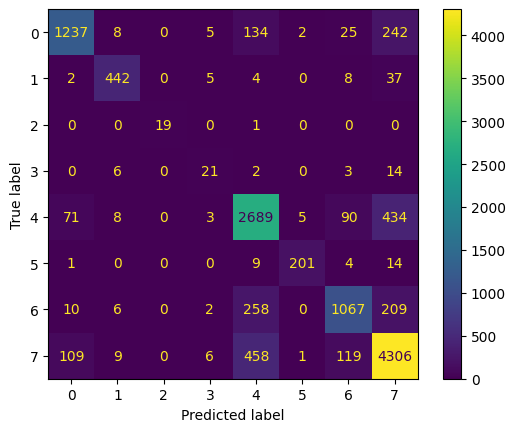

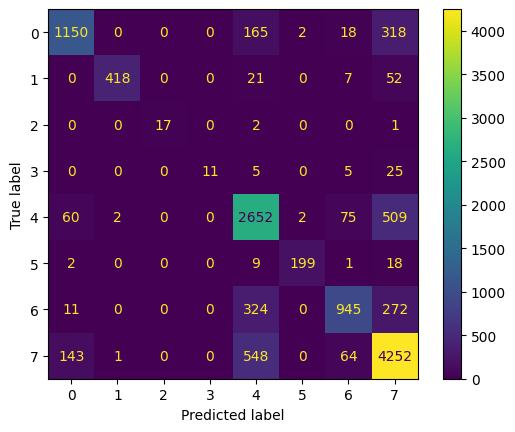

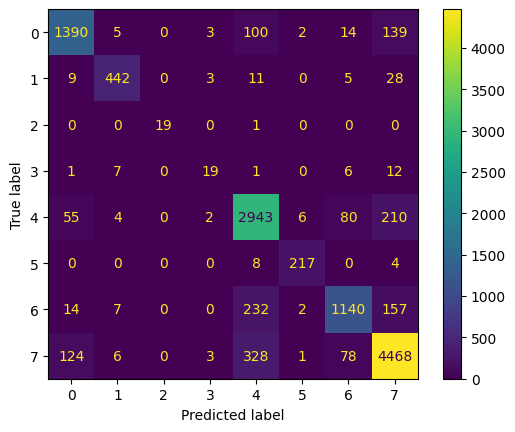

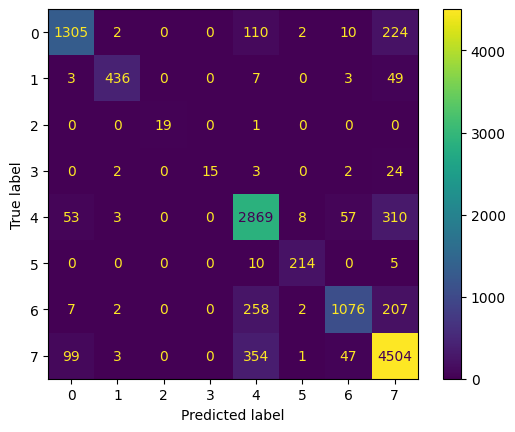

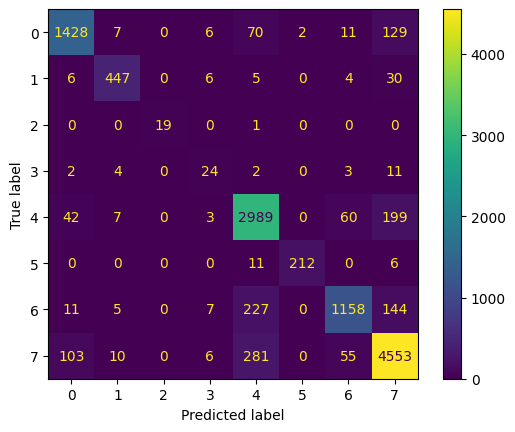

In [103]:
#plt.figure()
#plt.subplot(221)
y_pred1 = clf1.predict(bow1)
cm1 = confusion_matrix(df["func_class"], y_pred1)
plt = ConfusionMatrixDisplay(cm1).plot()


#plt.subplot(222)
y_pred2 = clf2.predict(bow2)
cm2 = confusion_matrix(df["func_class"], y_pred2)
cm_display2 = ConfusionMatrixDisplay(cm2).plot()


#plt.subplot(223)
y_pred3 = clf3.predict(bow3)
cm3 = confusion_matrix(df["func_class"], y_pred3)
cm_display3 = ConfusionMatrixDisplay(cm3).plot()


#plt.subplot(224)
y_pred4 = clf4.predict(bow4)
cm4 = confusion_matrix(df["func_class"], y_pred4)
cm_display4 = ConfusionMatrixDisplay(cm4).plot()


y_pred5 = clf5.predict(bow3)
cm5 = confusion_matrix(df["func_class"], y_pred5)
cm_display5 = ConfusionMatrixDisplay(cm5).plot()


#plt.show()

In [53]:
#expl = eli5.explain_weights(clf3, vec=vec3, top=15, target_names=bow3)

expl = eli5.show_weights(clf3, vec=vec3, top=15, target_names=bow3)

#img = eli5.format_as_image(expl)

#show_weights
#type(expl)
#eli5.format_as_image(expl)
expl
#type(img)

#image = expl.image
#heatmap = expl.targets[0].heatmap

#display(image) # the .image attribute is a PIL image
#print(heatmap) # the .heatmap attribute is a numpy array

In [36]:
eli5.show_prediction(clf3,df["func_body"][1] , vec=vec3,
                  target_names=bow3)

## Test

In [104]:
df_test = pd.read_csv('../../data/for_linear_models/test.csv' , header=0)#,  on_bad_lines='skip')
df_test

,compiller,version,compiler_option,name_hash,instructions_count,func_body,func_class
0,gcc,9.3.0,Ofast,c0a1c3d0f5693db431cf0af91a6cf5c8,222,"push r15', 'push r14', 'push r13', 'push r12',...",'Data structures'
1,gcc,9.3.0,Ofast,f6107b511a9a5d14f546840ab4f977c1,235,"push r15', 'push r14', 'push r13', 'push r12',...",System
2,gcc,10.2.1,Og,078b20586a67d3bd8640d912116986af,141,"push r14', 'lea rax, [ADDR]', 'push r13', 'pus...",Another
3,gcc,10.2.1,Og,b7a12725e3bda88dbc8659d995d871b0,43,"push r12', 'push rbp', 'push rbx', 'mov rcx, q...",System
4,gcc,9.3.0,Ofast,c3adbe2561228077a80f22185bf2f665,3,"mov esi, ADDR', 'jmp FCN', 'nop word [rax + rax]",Programming
...,...,...,...,...,...,...,...
3072,gcc,9.3.0,Ofast,b1f95b629c3a388f71dd3a907d46f5d3,24,"test rsi, rsi', 'je ADDR', 'push r12', 'mov r1...",'Data structures'
3073,gcc,10.2.1,Og,1e75530aa7839e80d54dcf39df19f73b,217,"push r12', 'lea r12, [ADDR]', 'lea rdi, [ADDR]...",Another
3074,gcc,10.2.1,Og,d3acac61f322edec5d85849c5f4275dc,15,"push rbx', 'mov rbx, qword [rdi + ADDR]', 'mov...",Programming
3075,gcc,9.3.0,Ofast,6514518732c7b6e1a8347db83a9a98d4,8,"mov rdi, r13', 'call FCN', 'lea rax, [ADDR]', ...",System


In [107]:
bow_test = vec3.transform(df_test["func_body"])
y_train = df_test["func_class"]

In [109]:
print("==============CountVectorizer 1-3 F1-SCORE - ", f1_score(y_train, clf3.predict(bow_test), average = 'micro'))
print("==============RandomForest 1-3 F1-SCORE - ", f1_score(y_train, clf5.predict(bow_test), average = 'micro'))

==============CountVectorizer 1-3 F1-SCORE -  0.7364315892102697
==============RandomForest 1-3 F1-SCORE -  0.7448813779655508
